In [1]:
from fireTS.models import NARX, DirectAutoRegressor
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib notebook

/home/jinyu/anaconda3/envs/fireTS/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Data
The data is generated by the [type-1-diabetes simulator](https://github.com/jxx123/simglucose) I developed.

In [2]:
data = pd.read_csv(os.path.join('.', 'data', 'adolescent#001.csv'))
data = data.set_index('Time')
data.index = pd.to_datetime(data.index)

<IPython.core.display.Javascript object>


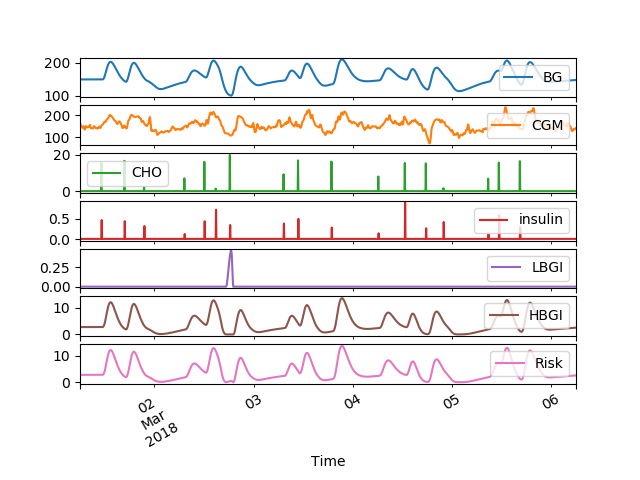

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd799eb9dd0>,
      dtype=object)

In [3]:
data.plot(subplots=True)

Predict the blood glucose level measured by the Continuous Glucose Monitor (CGM) using insulin and meal as the exogenous inputs.

In [4]:
ytrain = data['CGM'].iloc[:1000]
Xtrain = data.loc[:, ['insulin', 'CHO']].iloc[:1000, :]

ytest = data['CGM'].iloc[1000:-1]
Xtest = data.loc[:, ['insulin', 'CHO']].iloc[1000:-1, :]

# Build the NARX model
Here linearRegression is used as base model. The time series model we are building becomes an Autoregression with Exogenous Inputs (ARX) model. The autoregression order is set to 6, the orders of the exogenous inputs are both set to 3 and the delays of the exogenous inputs are both set to 0.

In [5]:
narx_mdl = NARX(LinearRegression(), auto_order=6, exog_order=[3, 3], exog_delay=[0, 0])

In [6]:
narx_mdl.fit(Xtrain, ytrain)

## Predict

In [7]:
ypred_narx = narx_mdl.predict(Xtest, ytest, step=6)
ypred_narx = pd.Series(ypred_narx, index=ytest.index)

<IPython.core.display.Javascript object>


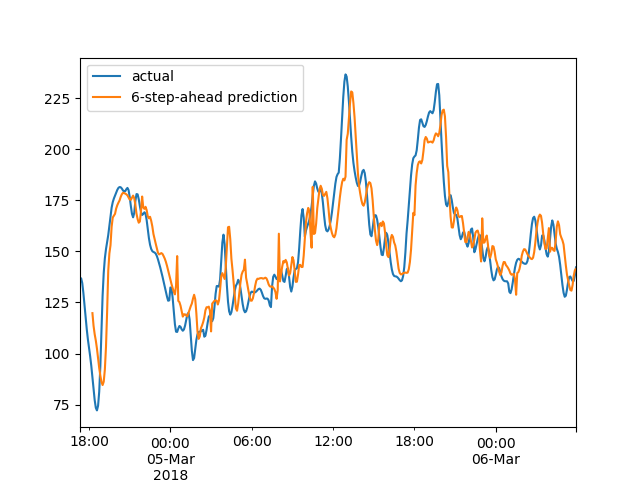

In [9]:
ytest.plot(label='actual')
ypred_narx.plot(label='6-step-ahead prediction')
plt.legend()

## Forecast

In [10]:
forecast_step = 20
yforecast_narx = narx_mdl.forecast(Xtest.iloc[:-forecast_step, :], 
                                   ytest.iloc[:-forecast_step], 
                                   step=forecast_step, 
                                   X_future=Xtest.iloc[-forecast_step:-1, :])

yforecast_narx = pd.Series(yforecast_narx, index=ytest.index[-forecast_step:])

<IPython.core.display.Javascript object>


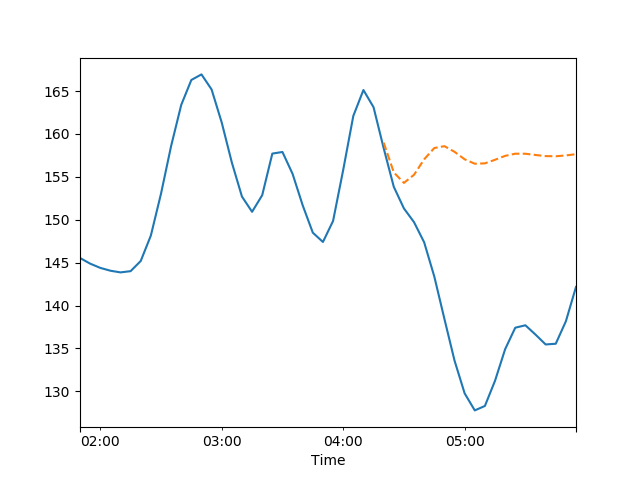

In [11]:
ytest.iloc[-50:].plot(label='actual')
yforecast_narx.plot(label='forecast', style='--')

## Forecast vs Predict

In [12]:
forecast_step = 6
yforecast_narx = narx_mdl.forecast(Xtest.iloc[:-forecast_step, :], 
                                   ytest.iloc[:-forecast_step], 
                                   step=forecast_step, 
                                   X_future=Xtest.iloc[-forecast_step:-1, :])

yforecast_narx = pd.Series(yforecast_narx, index=ytest.index[-forecast_step:])

# When forecast step and predict step are equal (in this case it is 6), 
# the 6th forecast value from 6 step before should be the same as the 
# predicted value of the last value in ytest. 
# (There is some numeric error in my implementation though.)
ypred_narx[-1] - yforecast_narx[-1]

-1.4210854715202004e-13

# Build the DirectAutoRegressor
The prediction step size must be specified in the constructor.

In [13]:
direct_mdl = DirectAutoRegressor(LinearRegression(), 
                                 auto_order=6, 
                                 exog_order=[3, 3], 
                                 exog_delay=[0, 0], 
                                 pred_step=6)

No prediction step can be set in the predict method.

In [14]:
direct_mdl.fit(Xtrain, ytrain)
ypred_direct = direct_mdl.predict(Xtest, ytest)
ypred_direct = pd.Series(ypred_direct, index=ytest.index)

<IPython.core.display.Javascript object>


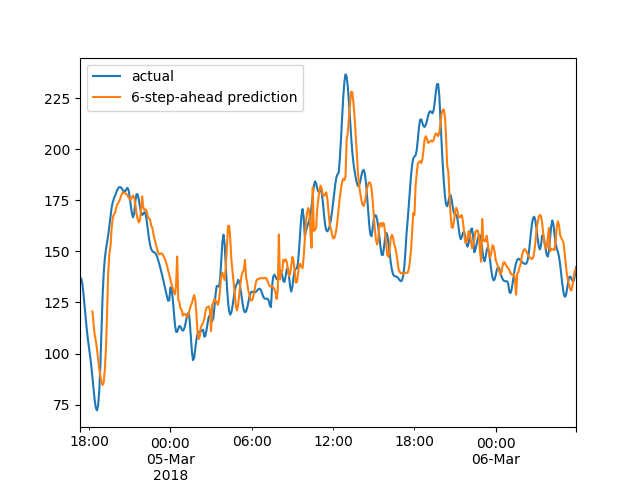

In [15]:
ytest.plot(label='actual')
ypred_direct.plot(label='6-step-ahead prediction')
plt.legend()